In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision.models import mobilenet_v3_large
import random
from torch.utils.data import WeightedRandomSampler

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
test transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [7]:
data = pd.read_csv('D://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [8]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [10]:
# train_labels = data_train["emotion"]
# class_counts = np.bincount(train_labels)
# class_weights = 1. / class_counts
# sample_weights = class_weights[train_labels]

# # Create a weighted sampler
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

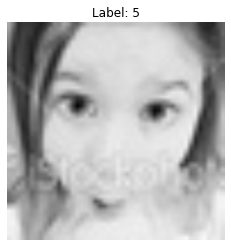

In [12]:
# Define the mean and std used for normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Denormalize function
def denormalize(tensor, mean, std):
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization: (t * s) + m
    return tensor

# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Denormalize the image
image = denormalize(image, mean, std)

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Clip the values to the valid range [0, 1]
image = image.clip(0, 1)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [13]:
image, label = train_dataset[0]
image.shape

torch.Size([3, 224, 224])

## Build Vision Transformer (ViT) Model

In [14]:
from torch import nn
import torch.nn.functional as F

In [15]:
class CNNBackbone(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=768):
        super().__init__()
        # Output channels for each convolution layer
        channels = [24, 48, 96, 192]
        
        # First conv: 3×3, stride 2, 3->24 channels
        # Input: 224×224 -> Output: 112×112
        self.conv1 = nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(channels[0])
        
        # Second conv: 3×3, stride 2, 24->48 channels
        # Input: 112×112 -> Output: 56×56
        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(channels[1])
        
        # Third conv: 3×3, stride 2, 48->96 channels
        # Input: 56×56 -> Output: 28×28
        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(channels[2])
        
        # Fourth conv: 3×3, stride 2, 96->192 channels
        # Input: 28×28 -> Output: 14×14
        self.conv4 = nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(channels[3])
        
        # Final 1×1 conv to match transformer dimension
        self.final_conv = nn.Conv2d(channels[3], embedding_dim, kernel_size=1)
        
    def forward(self, x):
        # Apply convolutions with BN and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final 1×1 conv without activation
        x = self.final_conv(x)
        return x

In [16]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [17]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [18]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [19]:
class ViTCNN(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.cnn_backbone = CNNBackbone(in_channels, embedding_dim)
        
        self.seq_length = (img_size // 16) ** 2  # 14x14 = 196
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.seq_length + 1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        # CNN backbone menghasilkan [B, 1, embedding_dim]
        cnn_features = self.cnn_backbone(pixel_values)
        
        x = cnn_features.flatten(2).transpose(1, 2)  # [B, 196, embed_dim]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)
        
        x = self.norm(x)
        
        cls_token_final = x[:, 0]

        logits = self.head(cls_token_final)
    
        return logits

## Model Training

In [20]:
model = ViTCNN(num_classes=len(class_names), in_channels=3, num_heads=8, embedding_dim=256, num_transformer_layers=6)

In [21]:
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 3, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViTCNN (ViTCNN)                                              [1, 3, 224, 224] [1, 7]          50,688          True
├─CNNBackbone (cnn_backbone)                                 [1, 3, 224, 224] [1, 256, 14, 14] --              True
│    └─Conv2d (conv1)                                        [1, 3, 224, 224] [1, 24, 112, 112] 672             True
│    └─BatchNorm2d (bn1)                                     [1, 24, 112, 112] [1, 24, 112, 112] 48              True
│    └─Conv2d (conv2)                                        [1, 24, 112, 112] [1, 48, 56, 56] 10,416          True
│    └─BatchNorm2d (bn2)                                     [1, 48, 56, 56] [1, 48, 56, 56] 96              True
│    └─Conv2d (conv3)                                        [1, 48, 56, 56] [1, 96, 28, 28] 41,568          True
│    └─BatchNorm2d (bn3)                                     [1, 96, 28

In [22]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define path
SAVE_PATH = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best metric for model saving
best_val_accuracy = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{train_loss / (batch_idx + 1):.4f}",
            "Acc": f"{correct / total:.4f}"
        })

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions for F1-score
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                "Acc": f"{val_correct / val_total:.4f}"
            })

    # Calculate validation accuracy, loss, and F1-score
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predicted, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Step the learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(SAVE_PATH, "coba_vit_cnn_backbone_best.pt")
        torch.save({
            "model_state_dict": model.state_dict(),
        }, model_path)
#         torch.save(model.state_dict(), model_path)
        print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

    # Save loss and accuracy plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(SAVE_PATH, "coba_vit_cnn_backbone_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(SAVE_PATH, "coba_vit_cnn_backbone_accuracy.png")
    plt.savefig(accuracy_plot_path)
    plt.close()

Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [02:25<00:00,  2.89it/s, Loss=1.7781, Acc=0.2560]


Epoch 1/1000: Train Loss: 1.7781, Train Acc: 0.2560


Epoch 1/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  7.00it/s, Loss=1.7780, Acc=0.2677]


Epoch 1/1000: Val Loss: 1.7780, Val Acc: 0.2677, Val F1: 0.2204
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.2677


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=1.6722, Acc=0.3279]


Epoch 2/1000: Train Loss: 1.6722, Train Acc: 0.3279


Epoch 2/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.74it/s, Loss=1.5983, Acc=0.3783]


Epoch 2/1000: Val Loss: 1.5983, Val Acc: 0.3783, Val F1: 0.3042
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.3783


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.5458, Acc=0.3943]


Epoch 3/1000: Train Loss: 1.5458, Train Acc: 0.3943


Epoch 3/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.85it/s, Loss=1.5181, Acc=0.4097]


Epoch 3/1000: Val Loss: 1.5181, Val Acc: 0.4097, Val F1: 0.3631
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4097


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.4602, Acc=0.4366]


Epoch 4/1000: Train Loss: 1.4602, Train Acc: 0.4366


Epoch 4/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.89it/s, Loss=1.4679, Acc=0.4220]


Epoch 4/1000: Val Loss: 1.4679, Val Acc: 0.4220, Val F1: 0.3954
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4220


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=1.3945, Acc=0.4601]


Epoch 5/1000: Train Loss: 1.3945, Train Acc: 0.4601


Epoch 5/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.96it/s, Loss=1.4309, Acc=0.4403]


Epoch 5/1000: Val Loss: 1.4309, Val Acc: 0.4403, Val F1: 0.4008
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4403


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.78it/s, Loss=1.3397, Acc=0.4809]


Epoch 6/1000: Train Loss: 1.3397, Train Acc: 0.4809


Epoch 6/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.85it/s, Loss=1.3950, Acc=0.4517]


Epoch 6/1000: Val Loss: 1.3950, Val Acc: 0.4517, Val F1: 0.4283
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4517


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.2748, Acc=0.5106]


Epoch 7/1000: Train Loss: 1.2748, Train Acc: 0.5106


Epoch 7/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.97it/s, Loss=1.4026, Acc=0.4600]


Epoch 7/1000: Val Loss: 1.4026, Val Acc: 0.4600, Val F1: 0.4561
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4600


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=1.2203, Acc=0.5309]


Epoch 8/1000: Train Loss: 1.2203, Train Acc: 0.5309


Epoch 8/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  6.99it/s, Loss=1.3756, Acc=0.4680]


Epoch 8/1000: Val Loss: 1.3756, Val Acc: 0.4680, Val F1: 0.4648
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4680


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.79it/s, Loss=1.1621, Acc=0.5548]


Epoch 9/1000: Train Loss: 1.1621, Train Acc: 0.5548


Epoch 9/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:06<00:00,  7.04it/s, Loss=1.3584, Acc=0.4787]


Epoch 9/1000: Val Loss: 1.3584, Val Acc: 0.4787, Val F1: 0.4757
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4787


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=1.1008, Acc=0.5794]


Epoch 10/1000: Train Loss: 1.1008, Train Acc: 0.5794


Epoch 10/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  7.01it/s, Loss=1.4255, Acc=0.4693]


Epoch 10/1000: Val Loss: 1.4255, Val Acc: 0.4693, Val F1: 0.4633
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.0366, Acc=0.6076]


Epoch 11/1000: Train Loss: 1.0366, Train Acc: 0.6076


Epoch 11/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.88it/s, Loss=1.4332, Acc=0.4713]


Epoch 11/1000: Val Loss: 1.4332, Val Acc: 0.4713, Val F1: 0.4602
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.79it/s, Loss=0.9566, Acc=0.6392]


Epoch 12/1000: Train Loss: 0.9566, Train Acc: 0.6392


Epoch 12/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.93it/s, Loss=1.4337, Acc=0.4713]


Epoch 12/1000: Val Loss: 1.4337, Val Acc: 0.4713, Val F1: 0.4651
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.8813, Acc=0.6702]


Epoch 13/1000: Train Loss: 0.8813, Train Acc: 0.6702


Epoch 13/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.89it/s, Loss=1.4922, Acc=0.4860]


Epoch 13/1000: Val Loss: 1.4922, Val Acc: 0.4860, Val F1: 0.4766
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\coba_vit_cnn_backbone_best.pt with val accuracy: 0.4860


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.8001, Acc=0.7015]


Epoch 14/1000: Train Loss: 0.8001, Train Acc: 0.7015


Epoch 14/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.81it/s, Loss=1.5162, Acc=0.4750]


Epoch 14/1000: Val Loss: 1.5162, Val Acc: 0.4750, Val F1: 0.4699
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [02:33<00:00,  2.75it/s, Loss=0.7181, Acc=0.7323]


Epoch 15/1000: Train Loss: 0.7181, Train Acc: 0.7323


Epoch 15/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.91it/s, Loss=1.6841, Acc=0.4680]


Epoch 15/1000: Val Loss: 1.6841, Val Acc: 0.4680, Val F1: 0.4548
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.5007, Acc=0.8302]


Epoch 16/1000: Train Loss: 0.5007, Train Acc: 0.8302


Epoch 16/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.80it/s, Loss=1.7066, Acc=0.4750]


Epoch 16/1000: Val Loss: 1.7066, Val Acc: 0.4750, Val F1: 0.4734
Current Learning Rate: 3e-06


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [02:33<00:00,  2.74it/s, Loss=0.4577, Acc=0.8463]


Epoch 17/1000: Train Loss: 0.4577, Train Acc: 0.8463


Epoch 17/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.88it/s, Loss=1.7383, Acc=0.4813]


Epoch 17/1000: Val Loss: 1.7383, Val Acc: 0.4813, Val F1: 0.4774
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=0.4271, Acc=0.8596]


Epoch 18/1000: Train Loss: 0.4271, Train Acc: 0.8596


Epoch 18/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.75it/s, Loss=1.7808, Acc=0.4780]


Epoch 18/1000: Val Loss: 1.7808, Val Acc: 0.4780, Val F1: 0.4751
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.79it/s, Loss=0.4028, Acc=0.8691]


Epoch 19/1000: Train Loss: 0.4028, Train Acc: 0.8691


Epoch 19/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.69it/s, Loss=1.8163, Acc=0.4797]


Epoch 19/1000: Val Loss: 1.8163, Val Acc: 0.4797, Val F1: 0.4751
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.74it/s, Loss=0.3832, Acc=0.8760]


Epoch 20/1000: Train Loss: 0.3832, Train Acc: 0.8760


Epoch 20/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.83it/s, Loss=1.8766, Acc=0.4730]


Epoch 20/1000: Val Loss: 1.8766, Val Acc: 0.4730, Val F1: 0.4691
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.3646, Acc=0.8824]


Epoch 21/1000: Train Loss: 0.3646, Train Acc: 0.8824


Epoch 21/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.85it/s, Loss=1.8953, Acc=0.4737]


Epoch 21/1000: Val Loss: 1.8953, Val Acc: 0.4737, Val F1: 0.4698
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=0.3326, Acc=0.8996]


Epoch 22/1000: Train Loss: 0.3326, Train Acc: 0.8996


Epoch 22/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.81it/s, Loss=1.9074, Acc=0.4773]


Epoch 22/1000: Val Loss: 1.9074, Val Acc: 0.4773, Val F1: 0.4724
Current Learning Rate: 3.0000000000000004e-07


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [02:33<00:00,  2.76it/s, Loss=0.3278, Acc=0.9021]


Epoch 23/1000: Train Loss: 0.3278, Train Acc: 0.9021


Epoch 23/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.47it/s, Loss=1.9088, Acc=0.4763]


Epoch 23/1000: Val Loss: 1.9088, Val Acc: 0.4763, Val F1: 0.4723
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000:   1%|▍                                         | 5/422 [00:01<02:38,  2.62it/s, Loss=0.3471, Acc=0.9062]


KeyboardInterrupt: 

# Testing

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = ViTCNN(num_classes=len(class_names), in_channels=3, num_heads=8, embedding_dim=256, num_transformer_layers=6)
best_model = best_model.to(DEVICE)

In [24]:
checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen//coba_vit_cnn_backbone_best.pt")
best_model.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_26124\1139574884.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [25]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

Testing: 100%|████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.45it/s, Loss=1.4984, Acc=0.4791]

Test Loss: 1.4984, Test Acc: 0.4791

Per-Class Accuracy:
Class 0: 0.3089
Class 1: 0.0222
Class 2: 0.2712
Class 3: 0.7154
Class 4: 0.3444
Class 5: 0.6226
Class 6: 0.5193

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.31      0.36       463
     Class 1       1.00      0.02      0.04        45
     Class 2       0.34      0.27      0.30       472
     Class 3       0.68      0.72      0.70       868
     Class 4       0.35      0.34      0.35       572
     Class 5       0.62      0.62      0.62       318
     Class 6       0.38      0.52      0.44       595

    accuracy                           0.48      3333
   macro avg       0.54      0.40      0.40      3333
weighted avg       0.48      0.48      0.47      3333



In [ ]:
def denormalize(image, mean, std):
    """
    Denormalize a normalized image tensor.

    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list): Mean used for normalization.
        std (list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    # Clone the image to avoid modifying the original
    image = image.clone()
    for c in range(image.shape[0]):
        image[c] = image[c] * std[c] + mean[c]
    return image

In [ ]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

# Store misclassified images, true labels, and predicted labels
misclassified_images = []
misclassified_true = []
misclassified_pred = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Store misclassified images
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_true.extend(targets[misclassified_mask].cpu().numpy())
            misclassified_pred.extend(predicted[misclassified_mask].cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

def plot_misclassified_images(class_id, num_images=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Plots misclassified images for a specific class.

    Args:
        class_id (int): The class ID to visualize misclassifications for.
        num_images (int): Number of misclassified images to display.
        mean (list): Mean used for normalization.
        std (list): Standard deviation used for normalization.
    """
    # Filter misclassified images for the specified class
    class_misclassified_indices = [i for i, true_label in enumerate(misclassified_true) if true_label == class_id]
    class_misclassified_images = [misclassified_images[i] for i in class_misclassified_indices]
    class_misclassified_true = [misclassified_true[i] for i in class_misclassified_indices]
    class_misclassified_pred = [misclassified_pred[i] for i in class_misclassified_indices]

    if not class_misclassified_images:
        print(f"No misclassified images found for Class {class_id}.")
        return

    # Limit the number of images to display
    num_images = min(num_images, len(class_misclassified_images))

    # Plot the misclassified images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = class_misclassified_images[i]

        # Denormalize the image
        img = denormalize(img, mean, std)

        # Convert from (C, H, W) to (H, W, C) and clip to valid range
        img = img.permute(1, 2, 0)  # Change tensor shape for matplotlib
        img = torch.clamp(img, 0, 1)  # Clip values to [0, 1]

        plt.imshow(img)
        plt.title(f"True: {class_misclassified_true[i]}\nPred: {class_misclassified_pred[i]}")
        plt.axis("off")
    plt.suptitle(f"Misclassified Images for Class {class_id}")
    plt.show()

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
plot_misclassified_images(class_id=6, num_images=15)